In [18]:
# 1. 环境设置

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import clip  # 确保已安装 OpenAI 的 CLIP 库
import pandas as pd

# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 配置参数
TEXT_EMBEDDINGS_PATH = './clip_embeddings/text_embeddings.pt'   # 替换为实际路径
IMAGE_EMBEDDINGS_PATH = './clip_embeddings/image_embeddings.pt' # 替换为实际路径
MAPPING_MODEL_PATH = 'text_to_image_embedder.pth'              # 映射网络路径
CVAEMODEL_PATH = 'clip_cvae_celeba_epochs_20.pth'             # ClipCVAE 模型路径，替换为实际路径
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [19]:
# 2. 定义数据集类

class CLIPEmbedMappingDatasetPrecomputed(Dataset):
    def __init__(self, text_embeddings_path, image_embeddings_path):
        """
        初始化数据集，加载预计算的嵌入
        :param text_embeddings_path: 文本嵌入文件路径
        :param image_embeddings_path: 图像嵌入文件路径
        """
        # 加载嵌入
        try:
            self.text_embeddings = torch.load(text_embeddings_path)
            self.image_embeddings = torch.load(image_embeddings_path)
        except Exception as e:
            print(f"Error loading embeddings: {e}")
            raise

        # 确认嵌入数量匹配
        assert len(self.text_embeddings) == len(self.image_embeddings), "文本和图像嵌入的数量不匹配"

        # 确保嵌入的 dtype 为 float32
        if self.text_embeddings.dtype != torch.float32:
            self.text_embeddings = self.text_embeddings.float()
            print("已将文本嵌入转换为 float32")
        if self.image_embeddings.dtype != torch.float32:
            self.image_embeddings = self.image_embeddings.float()
            print("已将图像嵌入转换为 float32")

    def __len__(self):
        return len(self.text_embeddings)

    def __getitem__(self, idx):
        return self.text_embeddings[idx], self.image_embeddings[idx]


In [20]:
# 3. 定义映射网络模型

class TextToImageEmbedder(nn.Module):
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedder, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

In [21]:
# 4. 加载训练好的映射网络

# 加载映射网络模型
mapping_embedder = TextToImageEmbedder(clip_dim=512, embed_dim=512).to(device)
mapping_embedder.load_state_dict(torch.load(MAPPING_MODEL_PATH))
mapping_embedder.eval()  # 设置为评估模式
print("映射网络模型已加载并设置为评估模式。")

映射网络模型已加载并设置为评估模式。


/tmp/ipykernel_8548/3346630029.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mapping_embedder.load_state_dict(torch.load(MAPPING_MODEL_PATH))


In [23]:
# 5. 加载 ClipCVAE 模型

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        # 将条件标签、图像和CLIP嵌入拼接
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        # 将潜在变量、条件标签和CLIP嵌入拼接
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

# 加载 ClipCVAE 模型（修正后的参数）
clip_cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=128, cond_dim=40, clip_dim=512).to(device)
clip_cvae.load_state_dict(torch.load(CVAEMODEL_PATH))
clip_cvae.eval()  # 设置为评估模式
print("ClipCVAE 模型已加载并设置为评估模式。")

ClipCVAE 模型已加载并设置为评估模式。


/tmp/ipykernel_8548/1172909070.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip_cvae.load_state_dict(torch.load(CVAEMODEL_PATH))


In [24]:
# 6. 定义属性向量转换函数

def text_to_attr_vector(text_prompt, attr_names):
    """
    将文本提示中的属性转换为40维二进制向量。
    
    :param text_prompt: 文本提示字符串
    :param attr_names: 属性名称列表
    :return: 40维二进制向量（torch.Tensor）
    """
    # 提取属性关键词
    # 假设属性名称使用下划线连接，如 "Arched_Eyebrows"
    if "with" not in text_prompt:
        print(f"警告：文本提示 '{text_prompt}' 不包含 'with'。无法提取属性。")
        attributes = []
    else:
        attributes = [attr.strip() for attr in text_prompt.lower().split("with")[-1].split(",")]
        attributes = [attr.replace(" ", "_") for attr in attributes]
    
    # 初始化属性向量
    attr_vector = torch.zeros(len(attr_names), dtype=torch.float32)
    
    # 设置对应属性为1
    for attr in attributes:
        if attr in attr_names:
            idx = attr_names.index(attr)
            attr_vector[idx] = 1.0
        else:
            print(f"警告：属性 '{attr}' 不在 CelebA 属性列表中。")
    
    return attr_vector

In [25]:
# 7. 定义图像生成函数

def generate_images_from_text(text_prompts, clip_model, mapping_model, cvae_model, attr_names, device, num_images=16):
    """
    根据文本提示生成图像。
    
    :param text_prompts: 文本提示列表
    :param clip_model: CLIP 模型
    :param mapping_model: 文本到图像嵌入的映射网络
    :param cvae_model: ClipCVAE 模型
    :param attr_names: CelebA 属性名称列表
    :param device: 设备（CPU 或 GPU）
    :param num_images: 生成的图像数量
    :return: 生成的图像张量
    """
    clip_model.eval()
    mapping_model.eval()
    cvae_model.eval()
    
    with torch.no_grad():
        # 将文本提示编码为 CLIP 文本嵌入
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
        
        # 使用映射网络将文本嵌入映射为图像嵌入
        image_embeddings = mapping_model(text_embeddings).float()
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
        
        # 从文本提示中提取属性向量
        attr_vectors = []
        for prompt in text_prompts:
            attr_vec = text_to_attr_vector(prompt, attr_names)
            attr_vectors.append(attr_vec)
        attr_vectors = torch.stack(attr_vectors).to(device)  # [N, 40]
        
        # 获取条件向量
        cond = image_embeddings[:num_images]
        cond = cond  # [N, 512]
        
        # 生成潜在向量（从标准正态分布采样）
        latent_dim = cvae_model.latent_dim
        z = torch.randn(num_images, latent_dim).to(device)
        
        # 解码生成图像
        generated_images = cvae_model.decode(z, attr_vectors[:num_images], image_embeddings[:num_images])
        
        # 将图像张量移到 CPU 并转换为 numpy 数组
        generated_images = generated_images.cpu()
    
    return generated_images

In [26]:
# 8. 定义图像展示函数

def show_images(images, title="生成的图像"):
    """
    可视化图像张量。
    
    :param images: 图像张量 [N, C, H, W]
    :param title: 标题
    """
    grid_size = int(np.ceil(np.sqrt(len(images))))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    
    for idx, img in enumerate(images):
        row = idx // grid_size
        col = idx % grid_size
        ax = axes[row, col]
        img = img.permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # 反归一化，因为使用了 Tanh 激活
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    
    # 隐藏剩余的子图
    for idx in range(len(images), grid_size * grid_size):
        row = idx // grid_size
        col = idx % grid_size
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
# 9. 加载 CelebA 属性名称

# 假设您在预处理阶段已经有了属性名称列表
# 例如，从属性文件中提取
ATTR_NAMES_PATH = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'  # 替换为实际路径

# 读取属性文件以获取属性名称
attr_df = pd.read_csv(ATTR_NAMES_PATH, sep=',', header=0)
attr_names = [col for col in attr_df.columns if col not in ['image_id', 'partition', 'x_1', 'y_1', 'width', 'height']]
print("CelebA 属性名称:", attr_names)

CelebA 属性名称: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


警告：属性 'arched_eyebrows' 不在 CelebA 属性列表中。
警告：属性 'attractive' 不在 CelebA 属性列表中。
警告：属性 'big_lips' 不在 CelebA 属性列表中。
警告：属性 'smiling.' 不在 CelebA 属性列表中。
警告：属性 'bald' 不在 CelebA 属性列表中。
警告：属性 'goatee' 不在 CelebA 属性列表中。
警告：属性 'no_beard' 不在 CelebA 属性列表中。
警告：属性 'wearing_hat.' 不在 CelebA 属性列表中。
警告：属性 'heavy_makeup' 不在 CelebA 属性列表中。
警告：属性 'smiling' 不在 CelebA 属性列表中。
警告：属性 'wavy_hair' 不在 CelebA 属性列表中。
警告：属性 'young.' 不在 CelebA 属性列表中。
警告：属性 'narrow_eyes' 不在 CelebA 属性列表中。
警告：属性 'high_cheekbones' 不在 CelebA 属性列表中。
警告：属性 'straight_hair.' 不在 CelebA 属性列表中。
警告：属性 'big_nose' 不在 CelebA 属性列表中。
警告：属性 'rosy_cheeks' 不在 CelebA 属性列表中。
警告：属性 'wearing_lipstick.' 不在 CelebA 属性列表中。
警告：属性 'big_lips' 不在 CelebA 属性列表中。
警告：属性 'blond_hair' 不在 CelebA 属性列表中。
警告：属性 'smiling.' 不在 CelebA 属性列表中。
警告：属性 'gray_hair' 不在 CelebA 属性列表中。
警告：属性 'high_cheekbones' 不在 CelebA 属性列表中。
警告：属性 'oval_face.' 不在 CelebA 属性列表中。
警告：属性 'mustache' 不在 CelebA 属性列表中。
警告：属性 'receding_hairline' 不在 CelebA 属性列表中。
警告：属性 'smiling.' 不在 CelebA 属性列表中。
警告：属性 'bags_under_eyes' 

/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8548/1740476259.py:30: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}

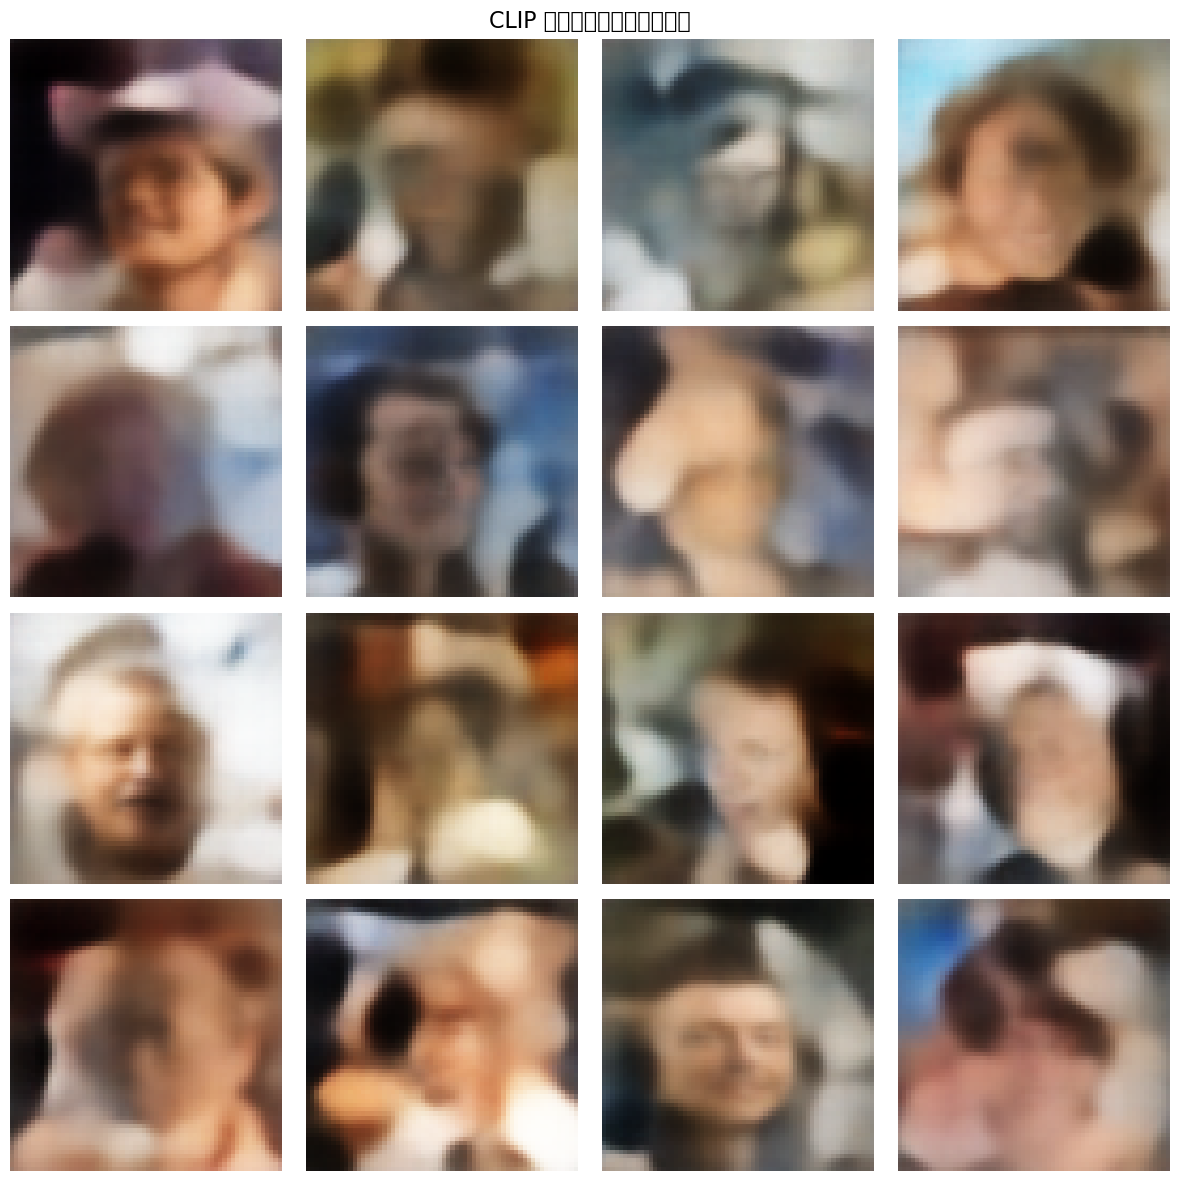

In [28]:
# 10. 生成并展示图像

# 定义文本提示
TEXT_PROMPTS = [
    "A person with Arched_Eyebrows, Attractive, Big_Lips, Smiling.",
    "A person with Bald, Goatee, No_Beard, Wearing_Hat.",
    "A person with Heavy_Makeup, Smiling, Wavy_Hair, Young.",
    "A person with Narrow_Eyes, High_Cheekbones, Straight_Hair.",
    "A person with Big_Nose, Rosy_Cheeks, Wearing_Lipstick.",
    "A person with Big_Lips, Blond_Hair, Smiling.",
    "A person with Gray_Hair, High_Cheekbones, Oval_Face.",
    "A person with Mustache, Receding_Hairline, Smiling.",
    "A person with Bags_Under_Eyes, Black_Hair, Attractive.",
    "A person with Big_Nose, Wavy_Hair, Wearing_Earrings.",
    "A person with Blurry, Male, Straight_Hair.",
    "A person with Attractive, Straight_Hair, Wearing_Necktie.",
    "A person with Mouth_Slightly_Open, Wavy_Hair, Young.",
    "A person with Receding_Hairline, Big_Lips, Smiling.",
    "A person with Chubby, Attractive, Wearing_Necklace.",
    "A person with High_Cheekbones, Smiling, Wavy_Hair."
]

# 生成图像
generated_images = generate_images_from_text(
    text_prompts=TEXT_PROMPTS,
    clip_model=clip_model,
    mapping_model=mapping_embedder,
    cvae_model=clip_cvae,
    attr_names=attr_names,
    device=device,
    num_images=len(TEXT_PROMPTS)
)

# 显示生成的图像
show_images(generated_images, title="CLIP 引导的条件生成人脸图像")